In [9]:
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    adjusted_rand_score as ari_score, 
    accuracy_score as acc_score,
    normalized_mutual_info_score as nmi_score,
    f1_score 
)
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import sys
sys.path.append("../src")
from kmeans import *
from matcher import *
from blobs_dataset import *
from tools import *
from scores import *

from collections import Counter, defaultdict
from copy import copy

SEED = 0

# 1. Dataset 

In [2]:
full_size = 1000
test_shape = 0.2

n_clusters = 4
cluster_std = 3
n_features = 2
    
X_train, X_test, y_train, y_test = create_blobs_dataset(
    n_clusters, cluster_std, n_features, full_size, test_shape
)
train_size = len(y_train)
test_size = len(y_test)

In [3]:
forget_shape = 0.2

mask_forget, mask_retain = get_forget_retain_mask(train_size, forget_shape)
X_retain, y_retain = X_train[mask_retain], y_train[mask_retain]
X_forget, y_forget = X_train[mask_forget], y_train[mask_forget]
    
retain_size = X_retain.shape[0]
forget_size = X_forget.shape[0]
    
print("Full size: ", full_size)
print("Train size: ", train_size)
print("Test size: ", test_size)
print("Retain size: ", retain_size)
print("Forget size: ", forget_size) 

Full size:  1000
Train size:  800
Test size:  200
Retain size:  640
Forget size:  160


# 2.Model 

In [4]:
fixed_centers = np.array([
    [2,  2],
    [-2,  2],
    [2,  -2],
    [-2,  -2]]
)

for i, init_method in enumerate(["fixed_centers", "random_points", "random_min_max"]):
    mean_ari = 0
    for seed in range(0, 100):
        kmeans_origin = Simple_kMeans(
            n_clusters=n_clusters, 
            init_method=init_method,
            _centers = fixed_centers,
        )
        kmeans_origin.fit(X_train)
        ari = score_calculator(y_test, kmeans_origin.predict(X_test))["ARI"].iloc[0]
        mean_ari += ari
    print(init_method, mean_ari / 100)

fixed_centers 0.17502565746409945
random_points 0.1803861145306095
random_min_max 0.1803861145306095


# Model create 

In [16]:
kmeans_origin = Simple_kMeans(
    n_clusters=n_clusters, 
    init_method="random_points",
)
centers_origin, labels_origin, history_origin = kmeans_origin.fit(X_train)
labels_origin_pred = kmeans_origin.predict(X_test)

In [17]:
kmeans_retain = Simple_kMeans(
    n_clusters=n_clusters, 
    init_method="random_points",
)
centers_retain, labels_retain, history_retain = kmeans_retain.fit(X_retain)
labels_retain_pred = kmeans_retain.predict(X_test)

In [18]:
def simple_unlearn(model, X, labels, mask_retain):
    X_retain = X[mask_retain]
    labels_retain = labels[mask_retain]
    
    unlearn_model = copy(model)
    unlearn_model.cluster_centers = (
        unlearn_model._compute_cluster_centers(X_retain, labels_retain)
    )
    return unlearn_model

kmeans_unlearn = simple_unlearn(kmeans_origin, X_train, labels_origin, mask_retain)
labels_unlearn_pred = kmeans_unlearn.predict(X_test)

In [19]:
score_calculator(labels_retain_pred, labels_unlearn_pred)

,ACC,F1,ARI,NMI,classes
0,0.97,0.969846,0.919097,0.909401,4.0


In [22]:
score_calculator(y_test, labels_unlearn_pred)

,ACC,F1,ARI,NMI,classes
0,0.575,0.579731,0.190717,0.230182,4.0


In [23]:
score_calculator(y_test, labels_retain_pred)

,ACC,F1,ARI,NMI,classes
0,0.6,0.603461,0.220976,0.245802,4.0


In [25]:
def diff_centers(kmeans1, kmeans2):
    diff = np.linalg.norm(
        kmeans1.cluster_centers - kmeans2.cluster_centers, 
        axis=1
    ).mean()
    return diff

origin_retain_diff = diff_centers(kmeans_origin, kmeans_retain)
retain_unlearn_diff = diff_centers(kmeans_unlearn, kmeans_retain)

centers_diff_ratio = retain_unlearn_diff / origin_retain_diff
centers_diff_ratio

0.9955925881478002

# Analysis 

## Forget shape 

In [40]:
n_clusters = 4
cluster_std = 3
n_features = 2

full_size = 1000
test_shape = 0.2

forget_shape_arr = np.arange(0, 1, 0.05)
ari_arr = []
centers_diff_ratio_arr = []
for forget_shape in forget_shape_arr:
    X_train, X_test, y_train, y_test = create_blobs_dataset(
        n_clusters, cluster_std, n_features, full_size, test_shape
    )
    train_size = len(y_train)
    test_size = len(y_test)

    mask_forget, mask_retain = get_forget_retain_mask(train_size, forget_shape)
    X_retain, y_retain = X_train[mask_retain], y_train[mask_retain]
    X_forget, y_forget = X_train[mask_forget], y_train[mask_forget]

    kmeans_origin = Simple_kMeans(
        n_clusters=n_clusters, 
        init_method="random_points",
    )
    kmeans_origin.fit(X_train)
    labels_origin_pred = kmeans_origin.predict(X_test)
    
    kmeans_retain = Simple_kMeans(
        n_clusters=n_clusters, 
        init_method="random_points",
    )
    kmeans_retain.fit(X_retain)
    labels_retain_pred = kmeans_retain.predict(X_test)
    
    kmeans_unlearn = simple_unlearn(kmeans_origin, X_train, labels_origin, mask_retain)
    labels_unlearn_pred = kmeans_unlearn.predict(X_test)
    
    ari = score_calculator(labels_retain_pred, labels_unlearn_pred)["ARI"].iloc[0]
    
    origin_retain_diff = diff_centers(kmeans_origin, kmeans_retain)
    retain_unlearn_diff = diff_centers(kmeans_unlearn, kmeans_retain)
    if origin_retain_diff != 0:
        centers_diff_ratio = retain_unlearn_diff / origin_retain_diff 
    else:
        centers_diff_ratio = min(retain_unlearn_diff, 1)
    
    ari_arr.append(ari)
    centers_diff_ratio_arr.append(centers_diff_ratio)
    
ari_arr = np.array(ari_arr)
centers_diff_ratio_arr = np.array(centers_diff_ratio_arr)

In [41]:
from matplotlib import pyplot as plt

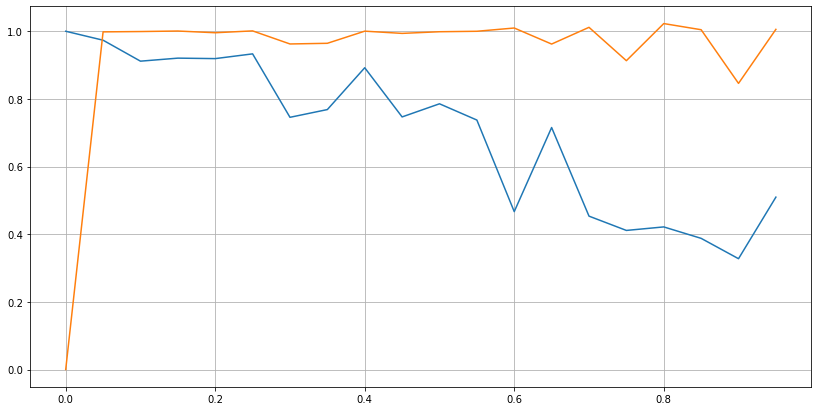

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(forget_shape_arr, ari_arr)
plt.plot(forget_shape_arr, centers_diff_ratio_arr)
plt.grid()